# Zipline Installation: Bundle Ingest & Algorithm Test

## Imports and Settings

We don't need much here since the imports all take place in the cell where we formulate the algorithm.

In [4]:
from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt

## Load Zipline extension

## Ingest Data

In [6]:
!zipline ingest

[2023-11-08T16:57:24+0000-INFO][zipline.data.bundles.core]
 Ingesting quandl
[2023-11-08T16:57:24+0000-INFO][zipline.data.bundles.quandl]
[2023-11-08T16:58:28+0000-INFO][zipline.data.bundles.quandl]
 Parsing raw data.
[2023-11-08T16:58:43+0000-INFO][zipline.data.bundles.quandl]
 Generating asset metadata.
/home/vk/miniforge3/envs/liveproject/lib/python3.10/site-packages/zipline/data/bundles/quandl.py:106: FutureWarning: The provided callable <function amin at 0x7f1cde377370> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
/home/vk/miniforge3/envs/liveproject/lib/python3.10/site-packages/zipline/data/bundles/quandl.py:106: FutureWarning: The provided callable <function amax at 0x7f1cde3771c0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used direct

## Run a simple test algorithm

In [8]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=100, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=300, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.loc[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.loc[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

DATE
2014-01-01         NaN
2014-01-02         NaN
2014-01-03   -0.000333
2014-01-06   -0.002512
2014-01-07    0.006082
Name: SP500, dtype: float64


/home/vk/miniforge3/envs/liveproject/lib/python3.10/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/home/vk/miniforge3/envs/liveproject/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/vk/miniforge3/envs/liveproject/lib/python3.10/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/vk/miniforge3/envs/liveproject/lib/python3.1

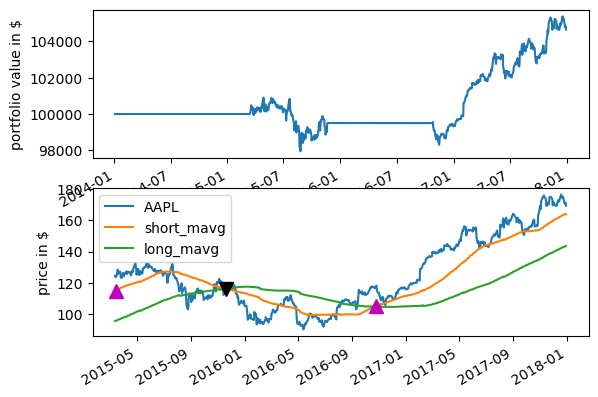

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1007 non-null   datetime64[ns, UTC]
 1   period_close             1007 non-null   datetime64[ns, UTC]
 2   positions                1007 non-null   object             
 3   short_exposure           1007 non-null   float64            
 4   long_exposure            1007 non-null   float64            
 5   ending_exposure          1007 non-null   float64            
 6   long_value               1007 non-null   float64            
 7   ending_cash              1007 non-null   float64            
 8   shorts_count             1007 non-null   int64              
 9   short_value              1007 non-null   float64            
 10  gross_leverage           1007 non-null   float64

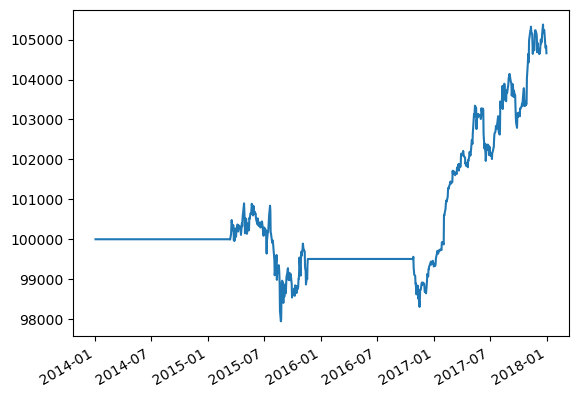

In [16]:
import pandas as pd
import pandas_datareader.data as web
from zipline import run_algorithm

start = pd.Timestamp("2014")
end = pd.Timestamp("2018")

sp500 = web.DataReader("SP500", "fred", start, end).SP500
benchmark_returns = sp500.pct_change(fill_method=None)
print(benchmark_returns.head())

result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,
    benchmark_returns=benchmark_returns,
    bundle="quandl",
    data_frequency="daily",
)

print(result.info())

result.portfolio_value.plot()
plt.show()